In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
colors = sns.color_palette(["#3E5C76", "#008080", "#9B4D96", "#FBB13C"])

In [2]:
def find_nearby_in_train(row, train_data, max_distance):
    # Extract chromosome and tss_distance for the row
    chromosome = row['variant_id'].split('_')[0]
    tss_distance = row['tss_distance']
    
    # Filter train_data for same chromosome and distance within the threshold
    same_chromosome = train_data[train_data['variant_id'].str.startswith(chromosome)]
    nearby = same_chromosome[abs(same_chromosome['tss_distance'] - tss_distance) <= max_distance]
    
    return nearby

def calculate_similarity_for_test(row, train_data, max_distance):
    nearby_in_train = find_nearby_in_train(row, train_data, max_distance)
    
    # Total number of nearby entries
    total_nearby = len(nearby_in_train)
    
    if total_nearby == 0:
        # If no nearby entries found, return 0 for both percentages and overlap lengths
        return 0.0, 0.0, 0, 0
    
    # Percentage of labels that match
    label_match_count = (nearby_in_train['label'] == row['label']).sum()
    label_match_percentage = (label_match_count / total_nearby) * 100
    
    # Percentage of bulks that match
    bulk_match_count = (nearby_in_train['bulk'] == row['bulk']).sum()
    bulk_match_percentage = (bulk_match_count / total_nearby) * 100
    
    # Calculate the maximum overlap length for matching labels
    label_match_nearby = nearby_in_train[nearby_in_train['label'] == row['label']]
    max_label_overlap_length = 0
    for _, train_row in label_match_nearby.iterrows():
        overlap_length = abs(train_row['tss_distance'] - row['tss_distance'])
        max_label_overlap_length = max(max_label_overlap_length, overlap_length)
    
    # Calculate the maximum overlap length for non-matching labels
    label_mismatch_nearby = nearby_in_train[nearby_in_train['label'] != row['label']]
    max_label_mismatch_overlap_length = 0
    for _, train_row in label_mismatch_nearby.iterrows():
        overlap_length = abs(train_row['tss_distance'] - row['tss_distance'])
        max_label_mismatch_overlap_length = max(max_label_mismatch_overlap_length, overlap_length)
    
    return label_match_percentage, bulk_match_percentage, max_label_overlap_length, max_label_mismatch_overlap_length

               variant_id tss_distance  label                  bulk
0    chr2_9843557_G_T_b38          203      1  Adipose_Subcutaneous
1  chr11_43856935_G_A_b38          531      0  Adipose_Subcutaneous
2   chr1_52602758_G_A_b38          386      0  Adipose_Subcutaneous
3  chr1_119000848_G_A_b38          -45      0  Adipose_Subcutaneous
4   chr1_16889585_T_C_b38          490      1  Adipose_Subcutaneous
               variant_id tss_distance  label                  bulk  \
0    chr2_9843557_G_T_b38          203      1  Adipose_Subcutaneous   
1  chr11_43856935_G_A_b38          531      0  Adipose_Subcutaneous   
2   chr1_52602758_G_A_b38          386      0  Adipose_Subcutaneous   
3  chr1_119000848_G_A_b38          -45      0  Adipose_Subcutaneous   
4   chr1_16889585_T_C_b38          490      1  Adipose_Subcutaneous   

   label_match_percentage  bulk_match_percentage  max_label_overlap_length  \
0               47.870528               9.880750                     984.0   
1        

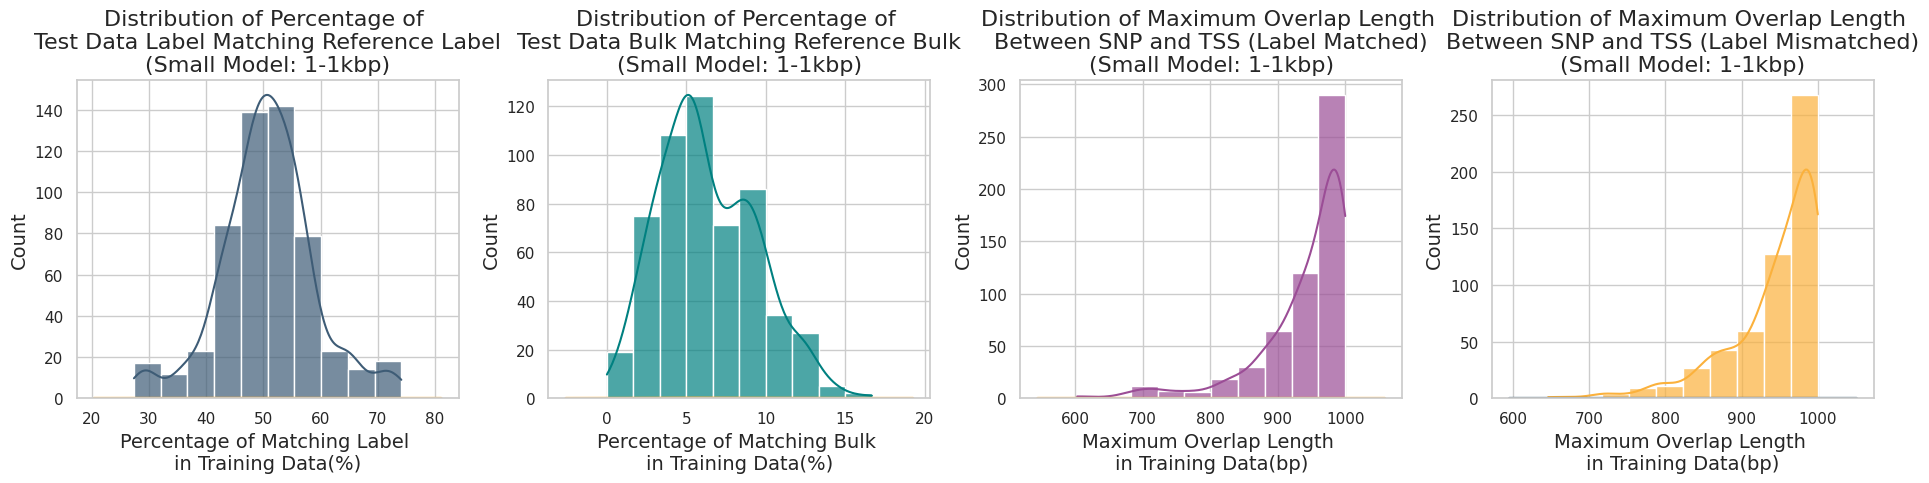

In [4]:
model_size = 'small'
max_distance = 1_000
train_data = pd.read_pickle('../datasets/' + model_size + '/train_' + model_size + '_post.pkl')[['variant_id','tss_distance','label','bulk']]
test_data = pd.read_pickle('../datasets/' + model_size + '/test_' + model_size + '_post.pkl')[['variant_id','tss_distance','label','bulk']]
print(test_data.head())

test_data[['label_match_percentage', 'bulk_match_percentage', 'max_label_overlap_length', 'max_label_mismatch_overlap_length']] = test_data.apply(
    lambda row: pd.Series(calculate_similarity_for_test(row, train_data, max_distance)), axis=1)
print(test_data.head())

# Set up the figure and axes for plotting in a single row
plt.figure(figsize=(19, 5))

# Plot label_match_percentage distribution
plt.subplot(1, 4, 1)
sns.histplot(test_data['label_match_percentage'], kde=True, color=colors[0], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['label_match_percentage'], color=colors[3], lw=2)
plt.title('Distribution of Percentage of \nTest Data Label Matching Reference Label\n(Small Model: 1-1kbp)', fontsize=16)
plt.xlabel('Percentage of Matching Label \nin Training Data(%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot bulk_match_percentage distribution
plt.subplot(1, 4, 2)
sns.histplot(test_data['bulk_match_percentage'], kde=True, color=colors[1], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['bulk_match_percentage'], color=colors[3], lw=2)
plt.title('Distribution of Percentage of \nTest Data Bulk Matching Reference Bulk\n(Small Model: 1-1kbp)', fontsize=16)
plt.xlabel('Percentage of Matching Bulk \nin Training Data(%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot max_label_overlap_length distribution
plt.subplot(1, 4, 3)
sns.histplot(test_data['max_label_overlap_length'], kde=True, color=colors[2], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['max_label_overlap_length'], color=colors[3], lw=2)
plt.title('Distribution of Maximum Overlap Length \nBetween SNP and TSS (Label Matched)\n(Small Model: 1-1kbp)', fontsize=16)
plt.xlabel('Maximum Overlap Length \nin Training Data(bp)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot max_label_mismatch_overlap_length distribution
plt.subplot(1, 4, 4)
sns.histplot(test_data['max_label_mismatch_overlap_length'], kde=True, color=colors[3], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['max_label_mismatch_overlap_length'], color=colors[0], lw=2)
plt.title('Distribution of Maximum Overlap Length \nBetween SNP and TSS (Label Mismatched)\n(Small Model: 1-1kbp)', fontsize=16)
plt.xlabel('Maximum Overlap Length \nin Training Data(bp)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.savefig("images/split-kde-" + model_size + ".png", dpi=300, bbox_inches = 'tight')
plt.show()

               variant_id tss_distance  label                  bulk
0   chr11_8965891_C_T_b38         1117      1  Adipose_Subcutaneous
1   chr12_8234275_C_G_b38        -8673      0  Adipose_Subcutaneous
2    chr16_274479_C_G_b38        -1461      1  Adipose_Subcutaneous
3  chr17_82721579_T_A_b38         4896      0  Adipose_Subcutaneous
4   chr6_37695848_T_C_b38        -3458      0  Adipose_Subcutaneous
               variant_id tss_distance  label                  bulk  \
0   chr11_8965891_C_T_b38         1117      1  Adipose_Subcutaneous   
1   chr12_8234275_C_G_b38        -8673      0  Adipose_Subcutaneous   
2    chr16_274479_C_G_b38        -1461      1  Adipose_Subcutaneous   
3  chr17_82721579_T_A_b38         4896      0  Adipose_Subcutaneous   
4   chr6_37695848_T_C_b38        -3458      0  Adipose_Subcutaneous   

   label_match_percentage  bulk_match_percentage  max_label_overlap_length  \
0               57.605985               8.977556                    9404.0   
1        

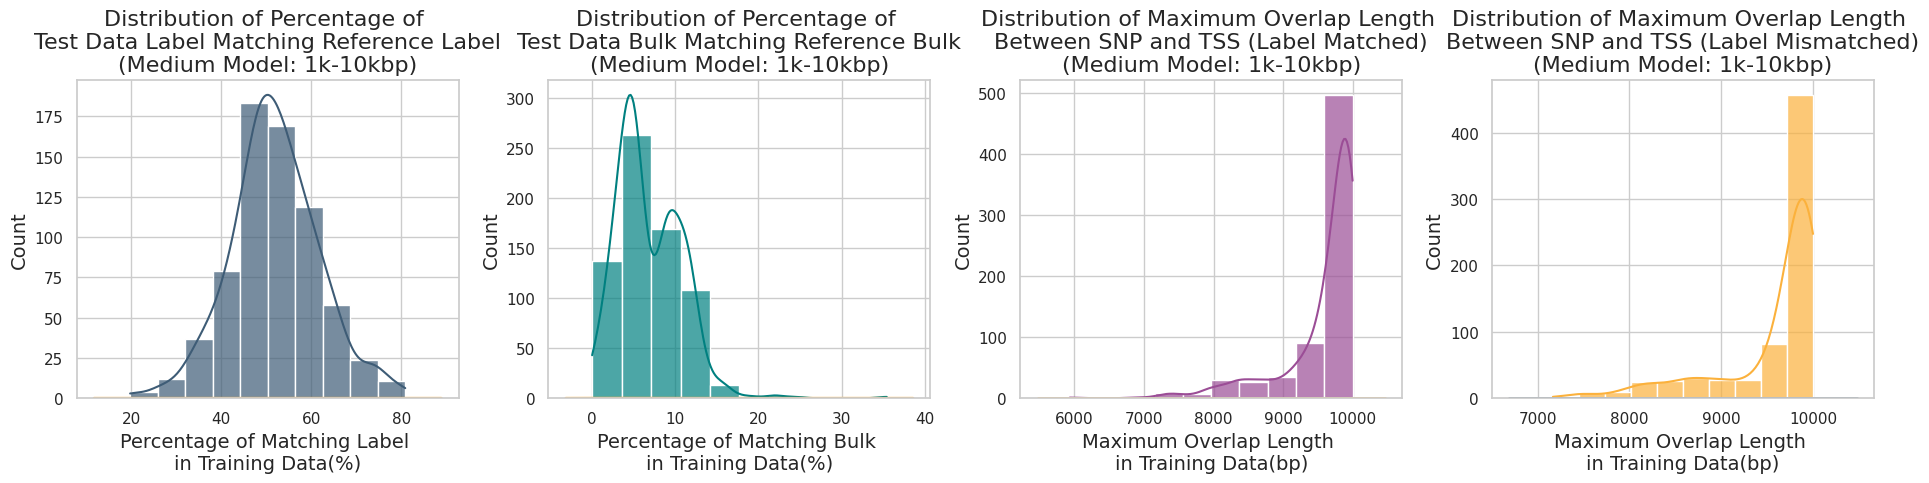

In [5]:
model_size = 'middle'
max_distance = 10_000
train_data = pd.read_pickle('../datasets/' + model_size + '/train_' + model_size + '_post.pkl')[['variant_id','tss_distance','label','bulk']]
test_data = pd.read_pickle('../datasets/' + model_size + '/test_' + model_size + '_post.pkl')[['variant_id','tss_distance','label','bulk']]
print(test_data.head())

test_data[['label_match_percentage', 'bulk_match_percentage', 'max_label_overlap_length', 'max_label_mismatch_overlap_length']] = test_data.apply(
    lambda row: pd.Series(calculate_similarity_for_test(row, train_data, max_distance)), axis=1)
print(test_data.head())

# Set up the figure and axes for plotting in a single row
plt.figure(figsize=(19, 5))

# Plot label_match_percentage distribution
plt.subplot(1, 4, 1)
sns.histplot(test_data['label_match_percentage'], kde=True, color=colors[0], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['label_match_percentage'], color=colors[3], lw=2)
plt.title('Distribution of Percentage of \nTest Data Label Matching Reference Label\n(Medium Model: 1k-10kbp)', fontsize=16)
plt.xlabel('Percentage of Matching Label \nin Training Data(%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot bulk_match_percentage distribution
plt.subplot(1, 4, 2)
sns.histplot(test_data['bulk_match_percentage'], kde=True, color=colors[1], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['bulk_match_percentage'], color=colors[3], lw=2)
plt.title('Distribution of Percentage of \nTest Data Bulk Matching Reference Bulk\n(Medium Model: 1k-10kbp)', fontsize=16)
plt.xlabel('Percentage of Matching Bulk \nin Training Data(%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot max_label_overlap_length distribution
plt.subplot(1, 4, 3)
sns.histplot(test_data['max_label_overlap_length'], kde=True, color=colors[2], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['max_label_overlap_length'], color=colors[3], lw=2)
plt.title('Distribution of Maximum Overlap Length \nBetween SNP and TSS (Label Matched)\n(Medium Model: 1k-10kbp)', fontsize=16)
plt.xlabel('Maximum Overlap Length \nin Training Data(bp)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot max_label_mismatch_overlap_length distribution
plt.subplot(1, 4, 4)
sns.histplot(test_data['max_label_mismatch_overlap_length'], kde=True, color=colors[3], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['max_label_mismatch_overlap_length'], color=colors[0], lw=2)
plt.title('Distribution of Maximum Overlap Length \nBetween SNP and TSS (Label Mismatched)\n(Medium Model: 1k-10kbp)', fontsize=16)
plt.xlabel('Maximum Overlap Length \nin Training Data(bp)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.savefig("images/split-kde-" + model_size + ".png", dpi=300, bbox_inches = 'tight')
plt.show()

               variant_id tss_distance  label                  bulk
0   chr4_75482009_T_C_b38       -32208      1  Adipose_Subcutaneous
1  chr2_127354075_A_C_b38        59899      0  Adipose_Subcutaneous
2  chr3_151799505_C_T_b38       -14532      0  Adipose_Subcutaneous
3  chr22_23993034_C_A_b38        12565      1  Adipose_Subcutaneous
4  chr1_155062156_C_G_b38        11590      0  Adipose_Subcutaneous
               variant_id tss_distance  label                  bulk  \
0   chr4_75482009_T_C_b38       -32208      1  Adipose_Subcutaneous   
1  chr2_127354075_A_C_b38        59899      0  Adipose_Subcutaneous   
2  chr3_151799505_C_T_b38       -14532      0  Adipose_Subcutaneous   
3  chr22_23993034_C_A_b38        12565      1  Adipose_Subcutaneous   
4  chr1_155062156_C_G_b38        11590      0  Adipose_Subcutaneous   

   label_match_percentage  bulk_match_percentage  max_label_overlap_length  \
0               47.163121               8.510638                   99653.0   
1        

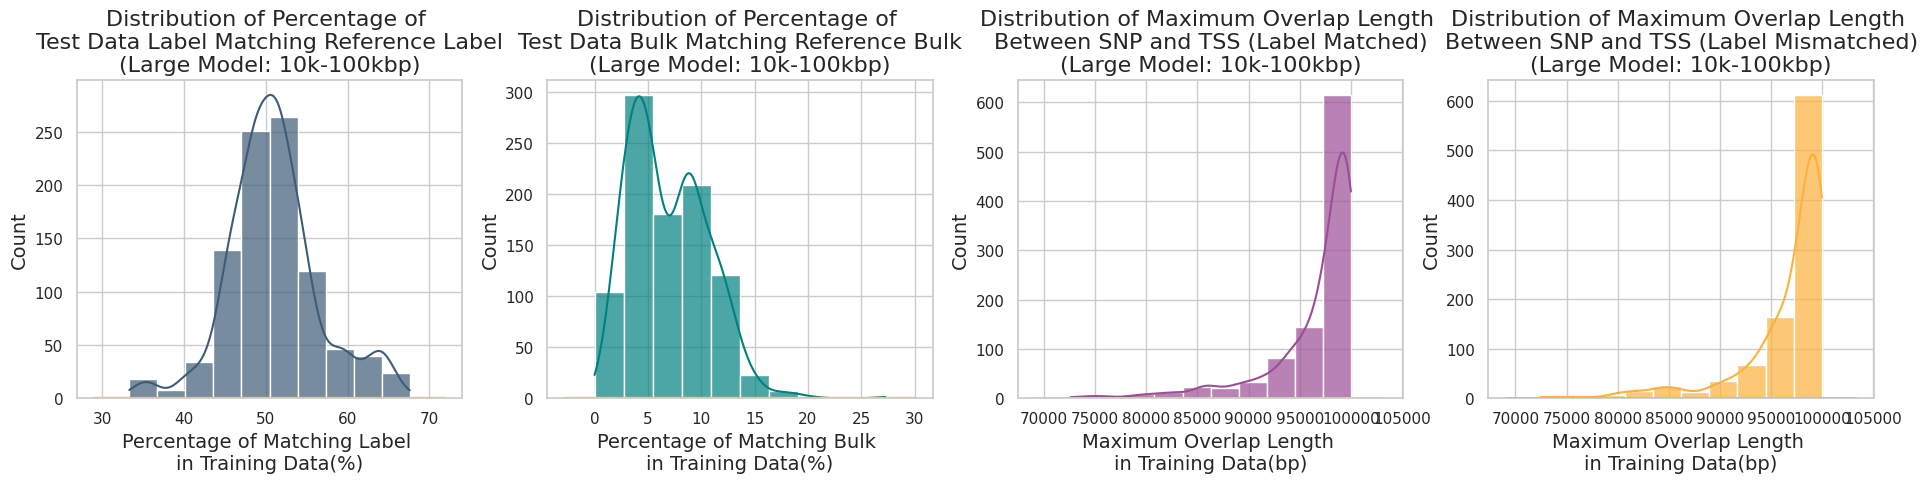

In [6]:
model_size = 'large'
max_distance = 100_000
train_data = pd.read_pickle('../datasets/' + model_size + '/train_' + model_size + '_post.pkl')[['variant_id','tss_distance','label','bulk']]
test_data = pd.read_pickle('../datasets/' + model_size + '/test_' + model_size + '_post.pkl')[['variant_id','tss_distance','label','bulk']]
print(test_data.head())

test_data[['label_match_percentage', 'bulk_match_percentage', 'max_label_overlap_length', 'max_label_mismatch_overlap_length']] = test_data.apply(
    lambda row: pd.Series(calculate_similarity_for_test(row, train_data, max_distance)), axis=1)
print(test_data.head())

# Set up the figure and axes for plotting in a single row
plt.figure(figsize=(19, 5))

# Plot label_match_percentage distribution
plt.subplot(1, 4, 1)
sns.histplot(test_data['label_match_percentage'], kde=True, color=colors[0], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['label_match_percentage'], color=colors[3], lw=2)
plt.title('Distribution of Percentage of \nTest Data Label Matching Reference Label\n(Large Model: 10k-100kbp)', fontsize=16)
plt.xlabel('Percentage of Matching Label \nin Training Data(%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot bulk_match_percentage distribution
plt.subplot(1, 4, 2)
sns.histplot(test_data['bulk_match_percentage'], kde=True, color=colors[1], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['bulk_match_percentage'], color=colors[3], lw=2)
plt.title('Distribution of Percentage of \nTest Data Bulk Matching Reference Bulk\n(Large Model: 10k-100kbp)', fontsize=16)
plt.xlabel('Percentage of Matching Bulk \nin Training Data(%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot max_label_overlap_length distribution
plt.subplot(1, 4, 3)
sns.histplot(test_data['max_label_overlap_length'], kde=True, color=colors[2], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['max_label_overlap_length'], color=colors[3], lw=2)
plt.title('Distribution of Maximum Overlap Length \nBetween SNP and TSS (Label Matched)\n(Large Model: 10k-100kbp)', fontsize=16)
plt.xlabel('Maximum Overlap Length \nin Training Data(bp)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot max_label_mismatch_overlap_length distribution
plt.subplot(1, 4, 4)
sns.histplot(test_data['max_label_mismatch_overlap_length'], kde=True, color=colors[3], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['max_label_mismatch_overlap_length'], color=colors[0], lw=2)
plt.title('Distribution of Maximum Overlap Length \nBetween SNP and TSS (Label Mismatched)\n(Large Model: 10k-100kbp)', fontsize=16)
plt.xlabel('Maximum Overlap Length \nin Training Data(bp)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.savefig("images/split-kde-" + model_size + ".png", dpi=300, bbox_inches = 'tight')
plt.show()

               variant_id tss_distance  label                  bulk
0  chr7_144361188_C_T_b38       166330      1  Adipose_Subcutaneous
1  chr15_82527557_T_G_b38       264747      1  Adipose_Subcutaneous
2  chr10_45947840_C_T_b38      -161781      1  Adipose_Subcutaneous
3   chr6_30077422_G_A_b38       143321      1  Adipose_Subcutaneous
4  chr17_46550855_T_G_b38       178000      0  Adipose_Subcutaneous
               variant_id tss_distance  label                  bulk  \
0  chr7_144361188_C_T_b38       166330      1  Adipose_Subcutaneous   
1  chr15_82527557_T_G_b38       264747      1  Adipose_Subcutaneous   
2  chr10_45947840_C_T_b38      -161781      1  Adipose_Subcutaneous   
3   chr6_30077422_G_A_b38       143321      1  Adipose_Subcutaneous   
4  chr17_46550855_T_G_b38       178000      0  Adipose_Subcutaneous   

   label_match_percentage  bulk_match_percentage  max_label_overlap_length  \
0               74.747475              11.616162                  893460.0   
1        

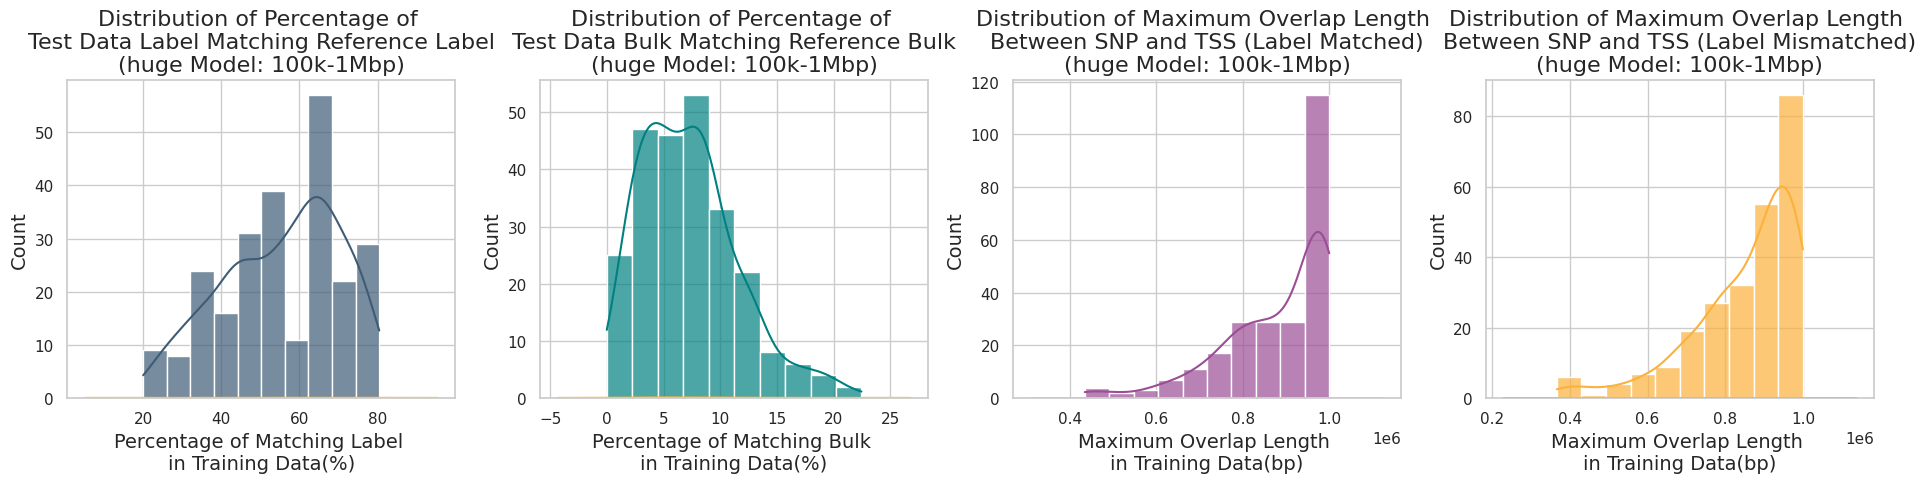

In [9]:
model_size = 'huge'
max_distance = 1_000_000
train_data = pd.read_pickle('../datasets/' + model_size + '/train_' + model_size + '_post.pkl')[['variant_id','tss_distance','label','bulk']]
test_data = pd.read_pickle('../datasets/' + model_size + '/test_' + model_size + '_post.pkl')[['variant_id','tss_distance','label','bulk']]
print(test_data.head())

test_data[['label_match_percentage', 'bulk_match_percentage', 'max_label_overlap_length', 'max_label_mismatch_overlap_length']] = test_data.apply(
    lambda row: pd.Series(calculate_similarity_for_test(row, train_data, max_distance)), axis=1)
print(test_data.head())

# Set up the figure and axes for plotting in a single row
plt.figure(figsize=(19, 5))

# Plot label_match_percentage distribution
plt.subplot(1, 4, 1)
sns.histplot(test_data['label_match_percentage'], kde=True, color=colors[0], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['label_match_percentage'], color=colors[3], lw=2)
plt.title('Distribution of Percentage of \nTest Data Label Matching Reference Label\n(huge Model: 100k-1Mbp)', fontsize=16)
plt.xlabel('Percentage of Matching Label \nin Training Data(%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot bulk_match_percentage distribution
plt.subplot(1, 4, 2)
sns.histplot(test_data['bulk_match_percentage'], kde=True, color=colors[1], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['bulk_match_percentage'], color=colors[3], lw=2)
plt.title('Distribution of Percentage of \nTest Data Bulk Matching Reference Bulk\n(huge Model: 100k-1Mbp)', fontsize=16)
plt.xlabel('Percentage of Matching Bulk \nin Training Data(%)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot max_label_overlap_length distribution
plt.subplot(1, 4, 3)
sns.histplot(test_data['max_label_overlap_length'], kde=True, color=colors[2], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['max_label_overlap_length'], color=colors[3], lw=2)
plt.title('Distribution of Maximum Overlap Length \nBetween SNP and TSS (Label Matched)\n(huge Model: 100k-1Mbp)', fontsize=16)
plt.xlabel('Maximum Overlap Length \nin Training Data(bp)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Plot max_label_mismatch_overlap_length distribution
plt.subplot(1, 4, 4)
sns.histplot(test_data['max_label_mismatch_overlap_length'], kde=True, color=colors[3], bins=10, alpha=0.7, stat='count')
sns.kdeplot(test_data['max_label_mismatch_overlap_length'], color=colors[0], lw=2)
plt.title('Distribution of Maximum Overlap Length \nBetween SNP and TSS (Label Mismatched)\n(huge Model: 100k-1Mbp)', fontsize=16)
plt.xlabel('Maximum Overlap Length \nin Training Data(bp)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.savefig("images/split-kde-" + model_size + ".png", dpi=300, bbox_inches = 'tight')
plt.show()